In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
def seq2seq_window_dataset(series, window_size, batch_size=32,
                            shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

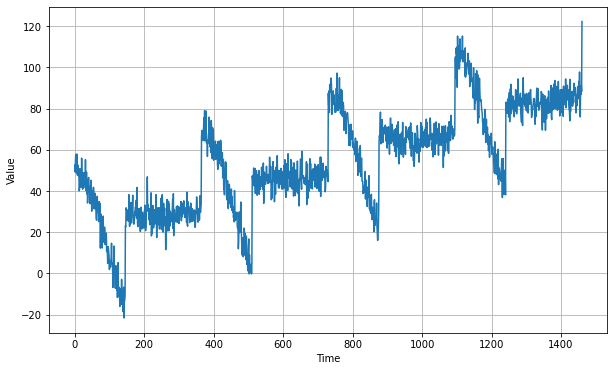

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                    batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
    strides=1, padding="causal",
    activation="relu",
    input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/30)
)
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

c:\Users\tuest\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 13s 44ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 1s 69ms/step - loss: 87.1256 - mae: 87.6250
Epoch 3/100
8/8 [==============================] - 1s 54ms/step - loss: 85.9688 - mae: 86.4681
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 84.5156 - mae: 85.0148
Epoch 5/100
8/8 [==============================] - 0s 41ms/step - loss: 82.7979 - mae: 83.2972
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 80.8555 - mae: 81.3548
Epoch 7/100
8/8 [==============================] - 1s 98ms/step - loss: 78.7325 - mae: 79.2318
Epoch 8/100
8/8 [==============================] - 1s 86ms/step - loss: 76.5042 - mae: 77.0036
Epoch 9/100
8/8 [==============================] - 1s 86ms/step - loss: 74.2760 - mae: 74.7756
Epoch 10/100
8/8 [==============================] - 1s 79ms/step - loss: 72.1081 - mae: 72.6077
Epoch 11/100
8/8 [==============================

(1e-08, 0.0001, 0.0, 30.0)

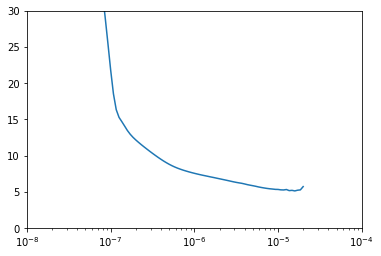

In [8]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                strides=1, padding="causal",
                activation="relu",
                input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only=True
)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(
    train_set,
    epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 17s 800ms/step - loss: 93.1480 - mae: 93.6479 - val_loss: 125.9309 - val_mae: 126.4309
Epoch 2/500
8/8 [==============================] - 2s 179ms/step - loss: 62.5160 - mae: 63.0154 - val_loss: 86.3144 - val_mae: 86.8144
Epoch 3/500
8/8 [==============================] - 2s 197ms/step - loss: 29.7858 - mae: 30.2824 - val_loss: 38.3316 - val_mae: 38.8298
Epoch 4/500
8/8 [==============================] - 2s 192ms/step - loss: 28.2600 - mae: 28.7572 - val_loss: 32.6747 - val_mae: 33.1727
Epoch 5/500
8/8 [==============================] - 2s 185ms/step - loss: 23.8387 - mae: 24.3352 - val_loss: 44.4113 - val_mae: 44.9098
Epoch 6/500
8/8 [==============================] - 2s 175ms/step - loss: 21.1148 - mae: 21.6095 - val_loss: 47.3076 - val_mae: 47.8068
Epoch 7/500
8/8 [==============================] - 3s 266ms/step - loss: 19.1475 - mae: 19.6409 - val_loss: 37.1166 - val_mae: 37.6147
Epoch 8/500
8/8 [==============================] - 2

In [11]:
model = keras.models.load_model('my_checkpoint.h5')
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1,0]

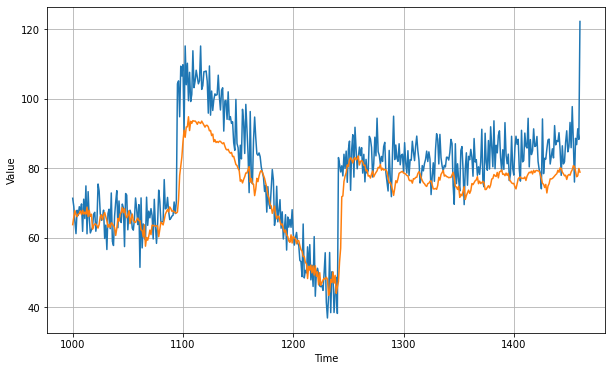

In [12]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.086449

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                    batch_size=128)

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=[None,1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal",
                            activation="relu")
        )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch/30)
)
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"]
)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

c:\Users\tuest\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 4s 97ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 1s 79ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 1s 61ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 1s 54ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 1s 61ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 1s 60ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 1s 53ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 1s 52ms/step - loss: 36.6836 - mae: 37.1823
Epoch 9/100
8/8 [==============================] - 1s 63ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 1s 55ms/step - loss: 27.9450 - mae: 28.4427
Epoch 11/100
8/8 [==============================]

(0.0001, 0.1, 0.0, 30.0)

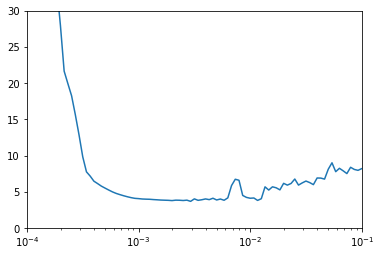

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 203ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 176ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 2s 206ms/step - loss: 35.1358 - mae: 35.6344 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 2s 227ms/step - loss: 30.8281 - mae: 31.3263 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 3s 321ms/step - loss: 24.9596 - mae: 25.4564 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 2s 159ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 2s 147ms/step - loss: 18.8909 - mae: 19.3859 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 2s 1

In [21]:
model = keras.models.load_model("my_checkpoint.h5")
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

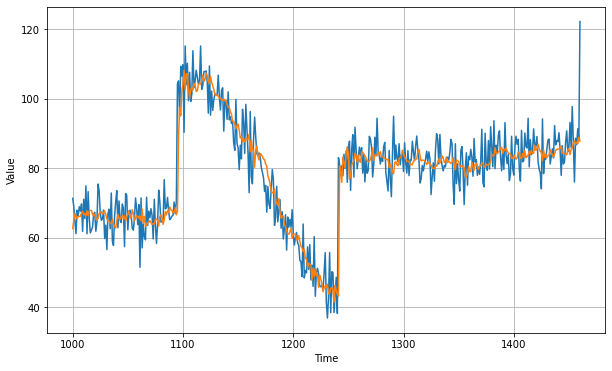

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.530406